In [2]:
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import os
from collections import defaultdict
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from ipywidgets import FileUpload, Output
from IPython.display import display

# Fixed paths and parameters
TRAIN_DIR = "DATASET/TRAIN/"
TEST_DIR = "DATASET/TEST/"
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
BATCH_SIZE = 32
EPOCHS_INITIAL = 25
EPOCHS_FINE_TUNE = 10
MODEL_DIR = "./model_uray"
CHECKPOINT_FILE = "model_checkpoint_best.keras"
CHECKPOINT_PATH = os.path.join(MODEL_DIR, CHECKPOINT_FILE)
LEARNING_RATE_FINE_TUNE = 1e-5

# Create model directory if not exists
os.makedirs(MODEL_DIR, exist_ok=True)


2024-11-23 01:21:12.934319: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-23 01:21:12.943970: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732299672.954760   18502 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732299672.957895   18502 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-23 01:21:12.969685: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [7]:
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2,
    rotation_range=60,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.4,
    zoom_range=0.5,
    brightness_range=[0.6, 1.4],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest",
)

test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
)

validation_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
)


Found 520 images belonging to 20 classes.
Found 120 images belonging to 20 classes.
Found 160 images belonging to 20 classes.


In [4]:
from tensorflow.keras.regularizers import l2
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output_layer = Dense(
    train_generator.num_classes,
    activation="softmax",
    kernel_regularizer=l2(1e-4),  # L2 Regularization
)(x)

model = Model(inputs=base_model.input, outputs=output_layer)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Load checkpoint if exists
if os.path.exists(CHECKPOINT_PATH):
    print("Checkpoint found. Loading model...")
    model = tf.keras.models.load_model(CHECKPOINT_PATH)
else:
    print("No checkpoint found. Training model from scratch...")


NameError: name 'train_generator' is not defined

In [49]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3),
    ModelCheckpoint(CHECKPOINT_PATH, monitor="val_accuracy", save_best_only=True, save_weights_only=False, verbose=1),
]


In [50]:
history = model.fit(
    train_generator,
    epochs=EPOCHS_INITIAL,
    validation_data=validation_generator,
    callbacks=callbacks,
)

# Fine-tuning
for layer in base_model.layers:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=LEARNING_RATE_FINE_TUNE, weight_decay=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

history_fine_tune = model.fit(
    train_generator,
    epochs=EPOCHS_FINE_TUNE,
    validation_data=validation_generator,
    callbacks=callbacks,
)


Epoch 1/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.6597 - loss: 1.0464
Epoch 1: val_accuracy improved from -inf to 0.65833, saving model to ./model_uray/model_checkpoint_best.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 530ms/step - accuracy: 0.6599 - loss: 1.0490 - val_accuracy: 0.6583 - val_loss: 1.1287 - learning_rate: 0.0010
Epoch 2/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.6443 - loss: 1.0592
Epoch 2: val_accuracy did not improve from 0.65833
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 237ms/step - accuracy: 0.6459 - loss: 1.0557 - val_accuracy: 0.6583 - val_loss: 1.0057 - learning_rate: 0.0010
Epoch 3/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.6980 - loss: 0.9548
Epoch 3: val_accuracy did not improve from 0.65833
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 295ms/step - accuracy: 0.6976 - loss: 0.9537 - val_accuracy: 0.6583 - val_loss: 0.9572 - learning_rate: 0.0010
Epoch 4/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.7313 - loss: 0.8730
Epoch 4: val_accurac

In [51]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.2%}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7393 - loss: 0.8904
Test Loss: 0.915, Test Accuracy: 73.75%


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step


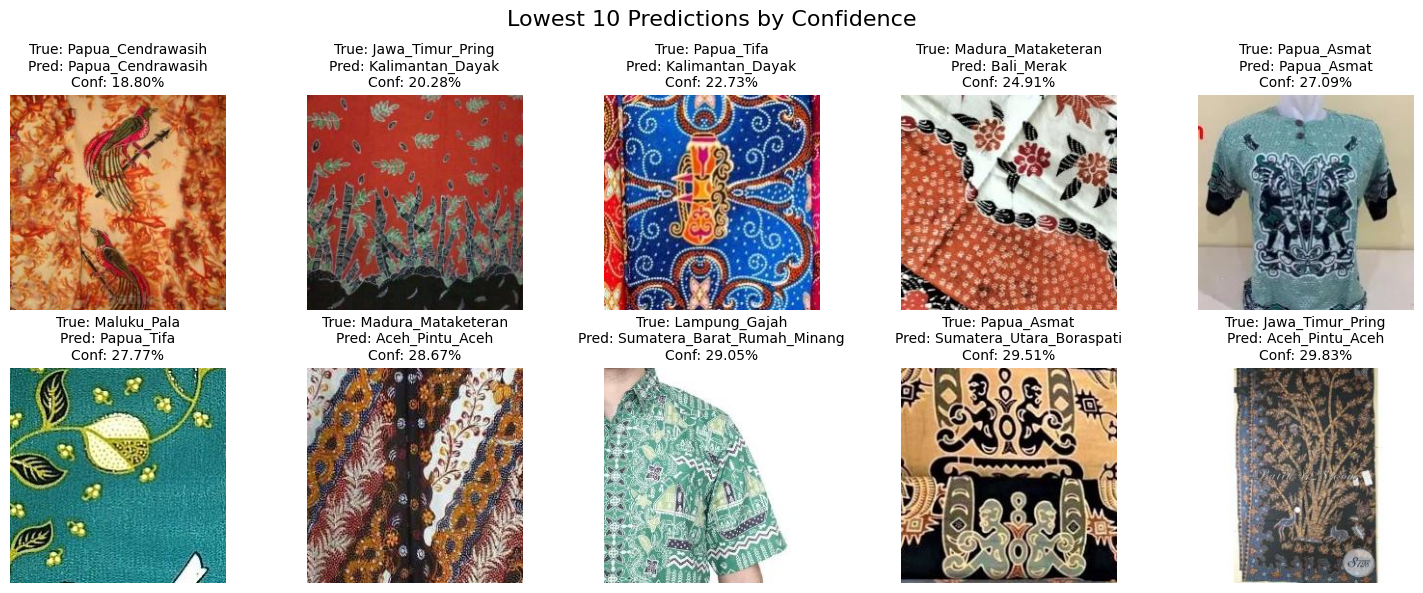

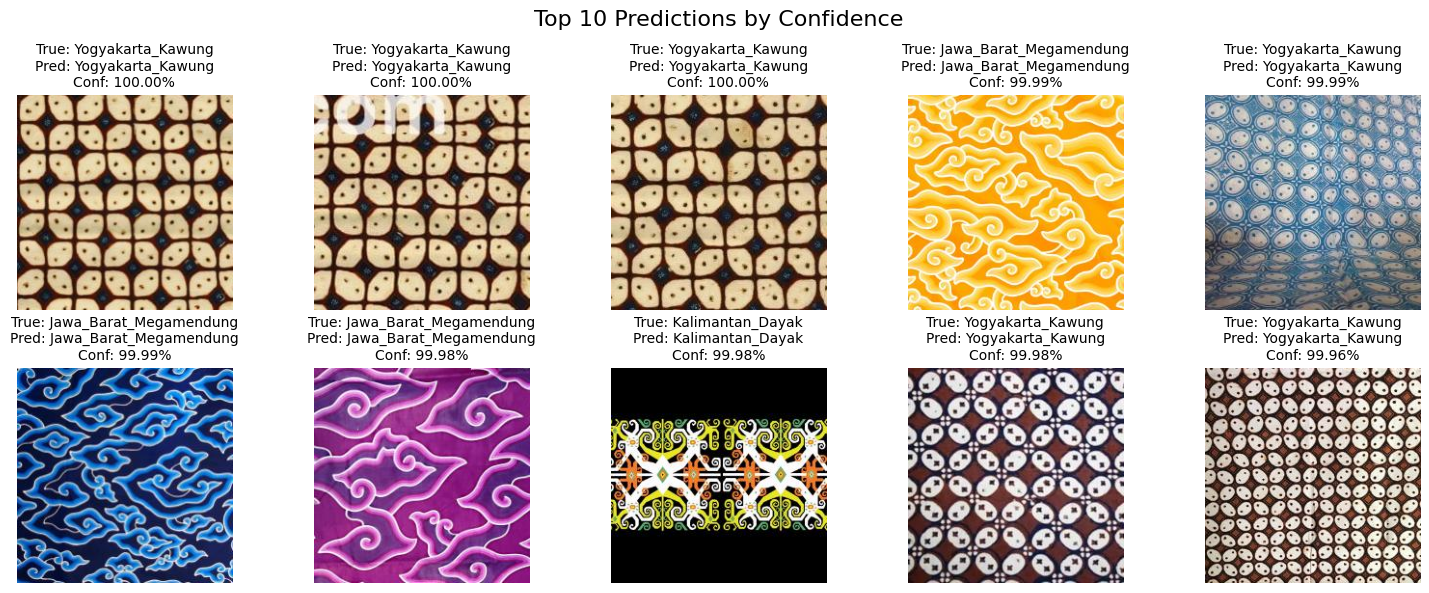

In [52]:
predictions = model.predict(test_generator)
class_labels = list(test_generator.class_indices.keys())
true_indices = test_generator.classes
predicted_indices = np.argmax(predictions, axis=1)
prediction_confidences = np.max(predictions, axis=1)

# Visualization function
def visualize_predictions(indices, title, rows=2, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 6))
    for i, idx in enumerate(indices):
        img_path = test_generator.filepaths[idx]
        img = plt.imread(img_path)
        true_label = class_labels[true_indices[idx]]
        predicted_label = class_labels[predicted_indices[idx]]
        confidence = prediction_confidences[idx] * 100

        ax = axes[i // cols, i % cols]
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(f"True: {true_label}\nPred: {predicted_label}\nConf: {confidence:.2f}%", fontsize=10)

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Lowest and highest confidence predictions
low_conf_indices = np.argsort(prediction_confidences)[:10]
high_conf_indices = np.argsort(prediction_confidences)[-10:][::-1]

visualize_predictions(low_conf_indices, "Lowest 10 Predictions by Confidence")
visualize_predictions(high_conf_indices, "Top 10 Predictions by Confidence")


In [53]:
def evaluate_by_folder(generator, predictions):
    folder_results = defaultdict(lambda: {"correct": 0, "total": 0})
    predicted_indices = np.argmax(predictions, axis=1)

    for filepath, true_idx, pred_idx in zip(generator.filepaths, generator.classes, predicted_indices):
        folder = os.path.basename(os.path.dirname(filepath))
        folder_results[folder]["total"] += 1
        if true_idx == pred_idx:
            folder_results[folder]["correct"] += 1

    return {folder: f"{result['correct']}/{result['total']}" for folder, result in folder_results.items()}

folder_results = evaluate_by_folder(test_generator, predictions)
print("Folder-wise Evaluation Results:")
for folder, result in folder_results.items():
    print(f"{folder}: {result}")


Folder-wise Evaluation Results:
Aceh_Pintu_Aceh: 5/8
Bali_Barong: 8/8
Bali_Merak: 5/8
DKI_Ondel_Ondel: 6/8
Jawa_Barat_Megamendung: 7/8
Jawa_Timur_Pring: 5/8
Kalimantan_Dayak: 8/8
Lampung_Gajah: 5/8
Madura_Mataketeran: 6/8
Maluku_Pala: 6/8
NTB_Lumbung: 6/8
Papua_Asmat: 2/8
Papua_Cendrawasih: 7/8
Papua_Tifa: 6/8
Solo_Parang: 6/8
Sulawesi_Selatan_Lontara: 5/8
Sumatera_Barat_Rumah_Minang: 6/8
Sumatera_Utara_Boraspati: 6/8
Yogyakarta_Kawung: 8/8
Yogyakarta_Parang: 5/8


In [ ]:
output = Output()
upload_widget = FileUpload(accept="image/*", multiple=False)
class_labels = list(test_generator.class_indices.keys())

def handle_upload(change):
    output.clear_output()
    with output:
        # Check if a file is uploaded
        if not upload_widget.value:
            print("Please upload an image file.")
            return
        
        # Access uploaded file content
        try:
            # If upload_widget.value is a dict
            if isinstance(upload_widget.value, dict):
                file = list(upload_widget.value.values())[0]
            # If upload_widget.value is a list or tuple
            elif isinstance(upload_widget.value, (list, tuple)):
                file = upload_widget.value[0]
            else:
                print("Unsupported upload format.")
                return

            temp_path = "./uploaded_image.jpg"  # Use a fixed temporary file name
            
            # Save the file to a temporary location
            with open(temp_path, "wb") as f:
                f.write(file["content"])
            
            # Load the model from the checkpoint
            if os.path.exists(CHECKPOINT_PATH):
                print("Loading model from checkpoint...")
                loaded_model = tf.keras.models.load_model(CHECKPOINT_PATH)
            else:
                print("No checkpoint found. Ensure the model is trained and checkpoint exists.")
                return
            
            # Load and preprocess the uploaded image
            img = load_img(temp_path, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
            img_array = img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
            
            # Make prediction
            preds = loaded_model.predict(img_array)
            predicted_idx = np.argmax(preds)
            confidence = preds[0][predicted_idx] * 100
            predicted_label = class_labels[predicted_idx]
            
            # Display the uploaded image with prediction result
            plt.figure(figsize=(6, 6))
            img_display = plt.imread(temp_path)
            plt.imshow(img_display)
            plt.axis("off")
            plt.title(f"Prediction: {predicted_label}\nConfidence: {confidence:.2f}%", fontsize=14)
            plt.show()
        
        except Exception as e:
            # Catch and display any errors
            print(f"Error during processing: {str(e)}")

# Observe the upload widget
upload_widget.observe(handle_upload, names="value")
display(upload_widget, output)

FileUpload(value=(), accept='image/*', description='Upload')

Output()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step

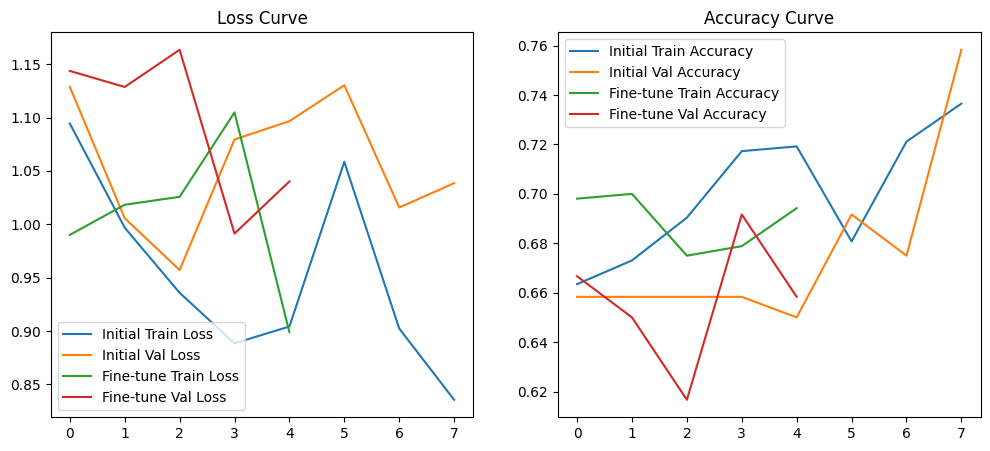

In [55]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Initial Train Loss")
plt.plot(history.history["val_loss"], label="Initial Val Loss")
plt.plot(history_fine_tune.history["loss"], label="Fine-tune Train Loss")
plt.plot(history_fine_tune.history["val_loss"], label="Fine-tune Val Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Initial Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Initial Val Accuracy")
plt.plot(history_fine_tune.history["accuracy"], label="Fine-tune Train Accuracy")
plt.plot(history_fine_tune.history["val_accuracy"], label="Fine-tune Val Accuracy")
plt.legend()
plt.title("Accuracy Curve")

plt.show()


In [ ]:
# # Path to the .keras model
# keras_model_path = "model_uray/model_checkpoint_best.keras"

# # Path to save the .h5 model
# h5_model_path = "model_uray/model_checkpoint_best.h5"

# # Step 1: Load the .keras model
# model = tf.keras.models.load_model(keras_model_path)
# print("Model loaded successfully.")

# # Step 2: Save the model in .h5 format
# model.save(h5_model_path, save_format="h5")
# print(f"Model saved successfully to {h5_model_path}.")

Model loaded successfully.
Model saved successfully to model_uray/model_checkpoint_best.h5.


In [ ]:
# model = tf.keras.models.load_model(keras_model_path)
# model_json = model.to_json()
# with open('model_architecture.json', 'w') as json_file:
#     json_file.write(model_json)